<a href="https://colab.research.google.com/github/nxf-emma/APS360-Artificial-Intelligence-Fundamentals/blob/main/small_dataset_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset as Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Composes several transforms together.

data_transform = transforms.Compose(
    [
        
        #convert image to grayscale
        transforms.Grayscale(num_output_channels=3),
        #randomly adding brightness 
        transforms.ColorJitter(brightness=(1,1.2)),
        #apply ramdom rotation from -30 to 30 degrees
        transforms.RandomRotation(30),
        #apply random horizontal flip with probability of 50% 
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        #normalize the data with 0.5 mean and variance.
        transforms.Normalize((0.5073955,), (0.25,), inplace=True)
       
    ])

#data_transform = transforms.ToTensor()


parent_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/small-dataset/'

training_set = torchvision.datasets.ImageFolder(parent_path+'train',data_transform)
valid_set = torchvision.datasets.ImageFolder(parent_path+'valid',data_transform)
test_set = torchvision.datasets.ImageFolder(parent_path+'test',data_transform)


'''
batch_size = 400
# two sub processes used for data loading
num_workers = 1

#get data loader
train_loader = torch.utils.data.DataLoader(training_set,batch_size = batch_size ,num_workers = num_workers,shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set,batch_size = batch_size ,num_workers = num_workers,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size = batch_size,num_workers = num_workers,shuffle = True)
'''

'\nbatch_size = 400\n# two sub processes used for data loading\nnum_workers = 1\n\n#get data loader\ntrain_loader = torch.utils.data.DataLoader(training_set,batch_size = batch_size ,num_workers = num_workers,shuffle = True)\nvalid_loader = torch.utils.data.DataLoader(valid_set,batch_size = batch_size ,num_workers = num_workers,shuffle = True)\ntest_loader = torch.utils.data.DataLoader(test_set,batch_size = batch_size,num_workers = num_workers,shuffle = True)\n'

In [4]:
'''
class small_dataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item
'''


'\nclass small_dataset(Dataset):\n\n    def __init__(self, data, transform):\n        self.data = data\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.data.shape[0])\n\n    def __getitem__(self, idx):\n        item = self.data[idx]\n        item = self.transform(item)\n        return item\n'

img_size = 48 

In [5]:
#Convolutional Neural Network Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv1 = nn.Conv2d(3, 5, 3, padding = 2) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(5, 25, 3) #in_channels, out_chanels, kernel_size
        self.conv3 = nn.Conv2d(25, 50, 3)
        self.conv4 = nn.Conv2d(50, 100, 3)
      
        self.dropout=nn.Dropout(0.3)
        self.fc1 = nn.Linear(100*1*1, 32) #chanels*dimension
        self.fc2 = nn.Linear(32, 7) #last output channel always = 7

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # 25x25
        x = self.pool(F.relu(self.conv2(x)))
        # 11x11
        x = self.pool(F.relu(self.conv3(x)))
        # 4x4
        x = self.pool(F.relu(self.conv4(x)))
        # 1x1
      
        x = x.view(-1, 100*1*1)

        x=F.relu(self.dropout(self.fc1(x)))
        x=F.relu(self.dropout(self.fc2(x)))
        '''
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        '''
        x = x.squeeze(1)
        
        return x

In [6]:
def get_accuracy(model, dataloader):
    

    correct = 0
    total = 0
    for imgs, labels in dataloader:
        
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [10]:
def train(model, train_data, val_data, batch_size=32, num_epochs=200, lr = 0.1):
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    iters, losses, train_acc, val_acc = [], [], [], []
    '''
    #we plot of images for verification
    data_iter = iter(train_loader)
    images, labels = data_iter.next()
    images = images.numpy()
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx], (1, 2, 0))
        #to disable the clip warning when ploting
        img = img/np.amax(img)
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        ax.set_title(classes[labels[idx]])
    '''
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            
        #print each epoch acc 
        print("epoch:", epoch, "acc = ", train_acc[epoch])

            

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


In [8]:
'''
train_path = '/content/gdrive/My Drive/aps360/train/'
val_path = '/content/gdrive/My Drive/aps360/val/'
test_path = '/content/gdrive/My Drive/aps360/test/'

train_data = datasets.DatasetFolder(training_set, loader=torch.load, extensions=('.tensor'))
val_data = datasets.DatasetFolder(valid_set, loader=torch.load, extensions=('.tensor'))
test_data = datasets.DatasetFolder(test_set, loader=torch.load, extensions=('.tensor'))
'''

"\ntrain_path = '/content/gdrive/My Drive/aps360/train/'\nval_path = '/content/gdrive/My Drive/aps360/val/'\ntest_path = '/content/gdrive/My Drive/aps360/test/'\n\ntrain_data = datasets.DatasetFolder(training_set, loader=torch.load, extensions=('.tensor'))\nval_data = datasets.DatasetFolder(valid_set, loader=torch.load, extensions=('.tensor'))\ntest_data = datasets.DatasetFolder(test_set, loader=torch.load, extensions=('.tensor'))\n"

epoch: 0 acc =  0.15714285714285714
epoch: 1 acc =  0.14285714285714285
epoch: 2 acc =  0.11428571428571428
epoch: 3 acc =  0.14285714285714285
epoch: 4 acc =  0.14285714285714285
epoch: 5 acc =  0.14285714285714285
epoch: 6 acc =  0.14285714285714285
epoch: 7 acc =  0.14285714285714285
epoch: 8 acc =  0.14285714285714285
epoch: 9 acc =  0.14285714285714285


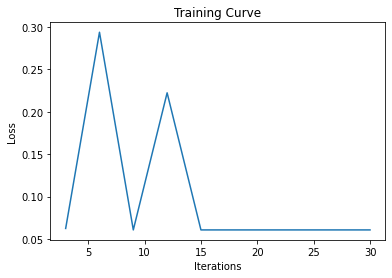

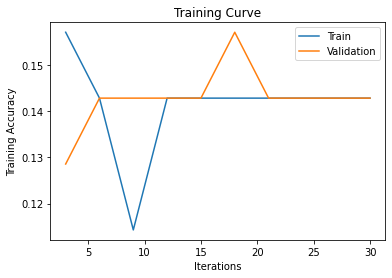

Final Training Accuracy: 0.14285714285714285
Final Validation Accuracy: 0.14285714285714285


In [9]:


#train
model = CNN()
use_cuda = True
model.cuda()

'''
training_set = '/content/drive/MyDrive/APS360 Team/aps360_dataset/small-dataset/train'
valid_set = '/content/drive/MyDrive/APS360 Team/aps360_dataset/small-dataset/valid'
#small_training_set = small_dataset(training_set,data_transform)
#small_valid_set = small_dataset(valid_set,data_transform)
'''
train(model,training_set,valid_set)